# Correct Answer vs 答案不正确 - Disagreement Score 分布对比

本 notebook 对比分析Correct Answer和答案不正确样本的 disagreement score 分布。

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
from scipy.stats import gaussian_kde

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16, 12)

%matplotlib inline

In [ ]:
def load_disagreement_scores(jsonl_file, filter_correct=True):
    """
    加载 JSONL 文件并提取 disagreement scores
    
    Args:
        jsonl_file: JSONL 文件路径
        filter_correct: True = 只保留Correct Answer的样本, False = 只保留答案不正确的样本
    """
    
    all_scores = []
    sample_max_scores = []
    sample_avg_scores = []
    turn_idx_scores = defaultdict(list)
    sample_info = []
    
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if line_num >1000:
                continue
            line = line.strip()
            if not line:
                continue
            
            try:
                data = json.loads(line)
                
                # 根据 filter_correct 参数决定是否保留该样本
                answer_in_content = data['answer'].lower() in data['turn_logprobs'][-1]['raw_content'].lower()
                
                if filter_correct:
                    # 只保留Correct Answer的样本（答案在内容中）
                    if not answer_in_content:
                        continue
                else:
                    # 只保留答案不正确的样本（答案不在内容中）
                    if answer_in_content:
                        continue
                
                turn_logprobs = data.get("turn_logprobs", [])
                
                sample_scores = []
                for turn in turn_logprobs:
                    if "disagreement_score" in turn and "error" not in turn:
                        score = turn["disagreement_score"]
                        all_scores.append(score)
                        sample_scores.append(score)
                        
                        turn_idx = turn.get("turn_idx", -1)
                        turn_idx_scores[turn_idx].append(score)
                
                if sample_scores:
                    sample_max_scores.append(max(sample_scores))
                    sample_avg_scores.append(np.mean(sample_scores))
                    sample_info.append({
                        'index': data.get('index', -1),
                        'max_score': max(sample_scores),
                        'avg_score': np.mean(sample_scores),
                        'num_turns': len(sample_scores)
                    })
                    
            except json.JSONDecodeError as e:
                print(f"⚠ Error parsing line {line_num}: {e}")
                continue
    
    return {
        'all_scores': np.array(all_scores),
        'sample_max_scores': np.array(sample_max_scores),
        'sample_avg_scores': np.array(sample_avg_scores),
        'turn_idx_scores': turn_idx_scores,
        'sample_info': sample_info
    }

In [43]:
# 加载数据
jsonl_file = "data/train_student_42step_32B_teacher_logprobs.jsonl"

print("正在加载答案正确的样本...")
correct_data = load_disagreement_scores(jsonl_file, filter_correct=True)
print(f"✓ 加载完成: {len(correct_data['sample_max_scores'])} 个样本")

print("\n正在加载Incorrect Answer的样本...")
incorrect_data = load_disagreement_scores(jsonl_file, filter_correct=False)
print(f"✓ 加载完成: {len(incorrect_data['sample_max_scores'])} 个样本")

正在加载答案正确的样本...
✓ 加载完成: 654 个样本

正在加载Incorrect Answer的样本...
✓ 加载完成: 346 个样本


In [44]:
# 提取分数数据
correct_scores = correct_data['sample_max_scores']
incorrect_scores = incorrect_data['sample_max_scores']

print(f"Correct Answer样本数: {len(correct_scores)}")
print(f"Incorrect Answer样本数: {len(incorrect_scores)}")

Correct Answer样本数: 654
Incorrect Answer样本数: 346


/tmp/ipykernel_6599/776505665.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot([correct_scores, incorrect_scores],
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  p


✓ 图表已保存: distribution_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  fig.canvas

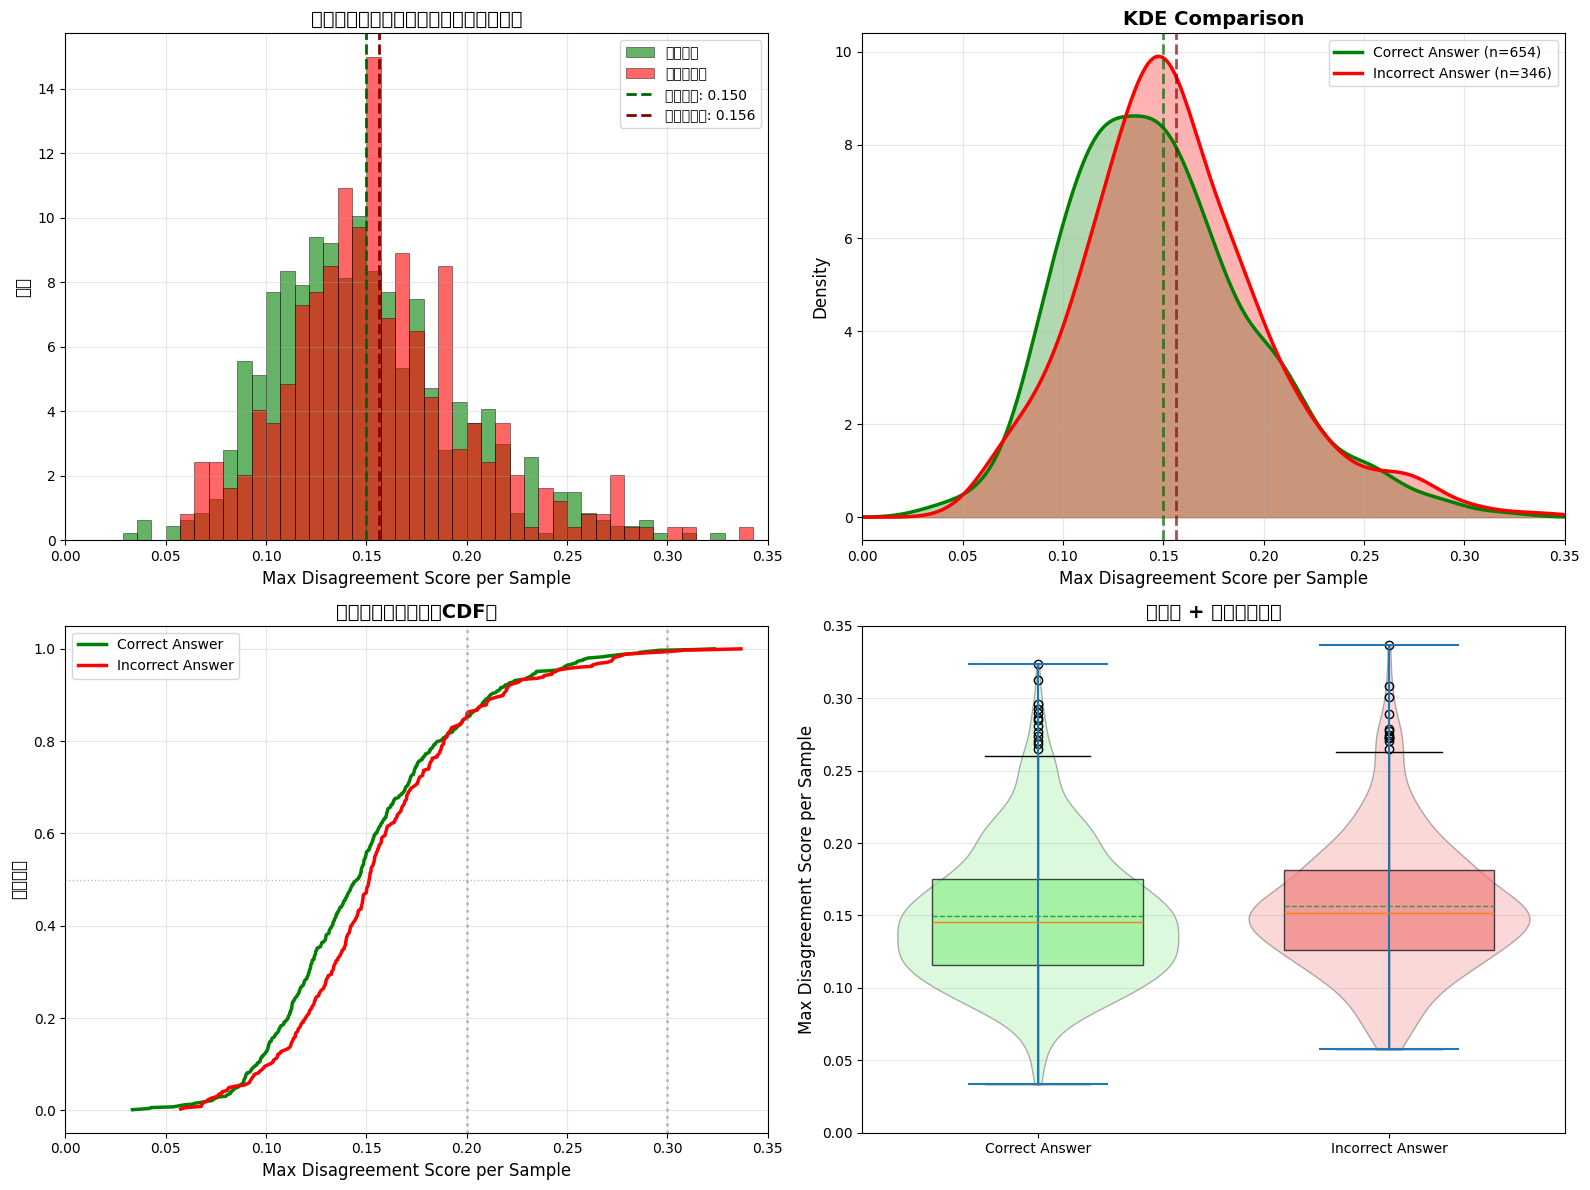

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 直方图对比 - 重叠显示
bins = np.linspace(0, 0.35, 50)
axes[0, 0].hist(correct_scores, bins=bins, alpha=0.6, label='答案正确', 
                color='green', density=True, edgecolor='black', linewidth=0.5)
axes[0, 0].hist(incorrect_scores, bins=bins, alpha=0.6, label='答案不正确', 
                color='red', density=True, edgecolor='black', linewidth=0.5)
axes[0, 0].axvline(np.mean(correct_scores), color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'正确均值: {np.mean(correct_scores):.3f}')
axes[0, 0].axvline(np.mean(incorrect_scores), color='darkred', linestyle='--', 
                   linewidth=2, label=f'不正确均值: {np.mean(incorrect_scores):.3f}')
axes[0, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 0].set_ylabel('密度', fontsize=12)
axes[0, 0].set_title('最大不一致分数分布对比（重叠直方图）', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper right')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 0.35)

# 2. 核密度估计（KDE）对比 - 更平滑的分布
kde_correct = gaussian_kde(correct_scores)
kde_incorrect = gaussian_kde(incorrect_scores)
x_range = np.linspace(0, 0.35, 500)

axes[0, 1].plot(x_range, kde_correct(x_range), linewidth=2.5, 
                label=f'Correct Answer (n={len(correct_scores)})', color='green')
axes[0, 1].plot(x_range, kde_incorrect(x_range), linewidth=2.5, 
                label=f'Incorrect Answer (n={len(incorrect_scores)})', color='red')
axes[0, 1].fill_between(x_range, kde_correct(x_range), alpha=0.3, color='green')
axes[0, 1].fill_between(x_range, kde_incorrect(x_range), alpha=0.3, color='red')
axes[0, 1].axvline(np.mean(correct_scores), color='darkgreen', 
                   linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].axvline(np.mean(incorrect_scores), color='darkred', 
                   linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('KDE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 0.35)

# 3. 累积分布函数（CDF）对比
sorted_correct = np.sort(correct_scores)
sorted_incorrect = np.sort(incorrect_scores)
cdf_correct = np.arange(1, len(sorted_correct) + 1) / len(sorted_correct)
cdf_incorrect = np.arange(1, len(sorted_incorrect) + 1) / len(sorted_incorrect)

axes[1, 0].plot(sorted_correct, cdf_correct, linewidth=2.5, 
                label='Correct Answer', color='green')
axes[1, 0].plot(sorted_incorrect, cdf_incorrect, linewidth=2.5, 
                label='Incorrect Answer', color='red')
axes[1, 0].axvline(0.2, color='gray', linestyle=':', alpha=0.5, linewidth=2)
axes[1, 0].axvline(0.3, color='gray', linestyle=':', alpha=0.5, linewidth=2)
axes[1, 0].axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[1, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 0].set_ylabel('累积概率', fontsize=12)
axes[1, 0].set_title('累积分布函数对比（CDF）', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 0.35)

# 4. 箱线图对比
bp = axes[1, 1].boxplot([correct_scores, incorrect_scores], 
                         labels=['Correct Answer', 'Incorrect Answer'],
                         patch_artist=True,
                         widths=0.6,
                         showmeans=True,
                         meanline=True)

# 设置箱线图颜色
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 添加小提琴图效果
parts = axes[1, 1].violinplot([correct_scores, incorrect_scores], 
                               positions=[1, 2], 
                               widths=0.8,
                               showmeans=False, 
                               showmedians=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.3)
    pc.set_edgecolor('black')
    pc.set_linewidth(1)

axes[1, 1].set_ylabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 1].set_title('箱线图 + 小提琴图对比', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('distribution_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ 图表已保存: distribution_comparison.png")
plt.show()

## Visualization Comparison

/tmp/ipykernel_6599/776505665.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot([correct_scores, incorrect_scores],
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/776505665.py:94: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  p


✓ 图表已保存: distribution_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  fig.canvas

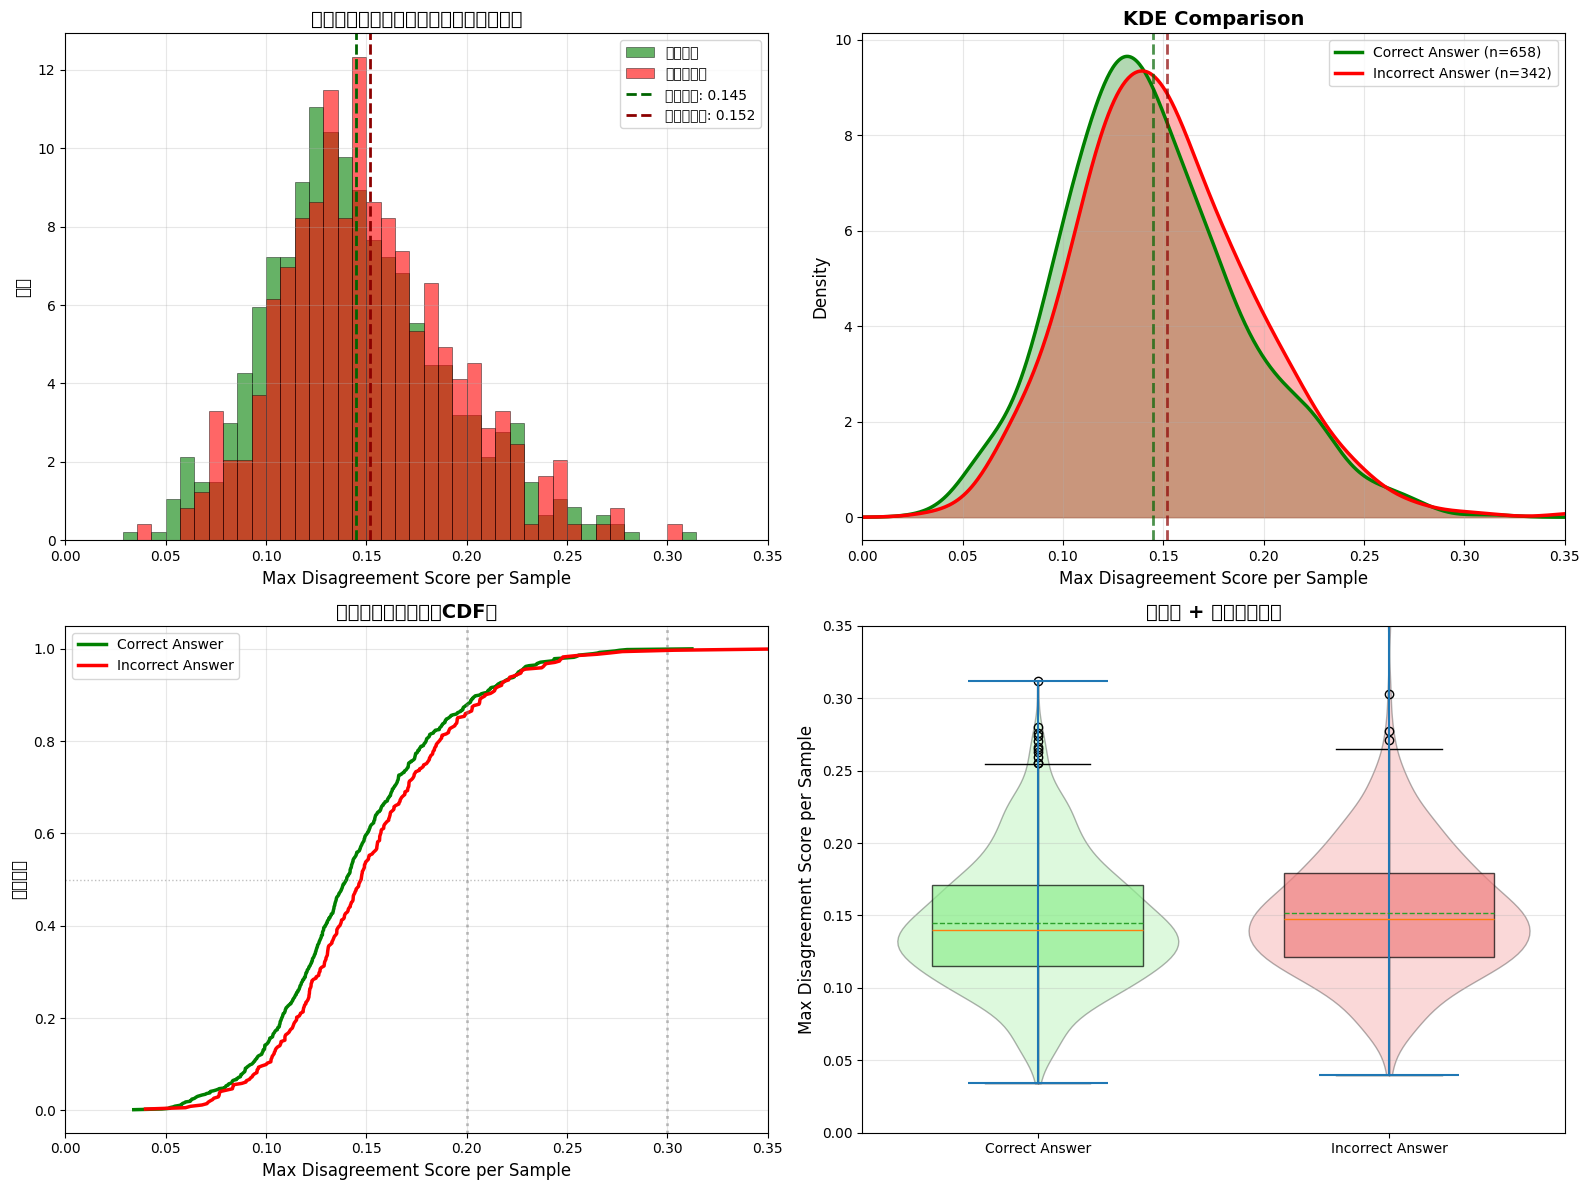

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 直方图对比 - 重叠显示
bins = np.linspace(0, 0.35, 50)
axes[0, 0].hist(correct_scores, bins=bins, alpha=0.6, label='答案正确', 
                color='green', density=True, edgecolor='black', linewidth=0.5)
axes[0, 0].hist(incorrect_scores, bins=bins, alpha=0.6, label='答案不正确', 
                color='red', density=True, edgecolor='black', linewidth=0.5)
axes[0, 0].axvline(np.mean(correct_scores), color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'正确均值: {np.mean(correct_scores):.3f}')
axes[0, 0].axvline(np.mean(incorrect_scores), color='darkred', linestyle='--', 
                   linewidth=2, label=f'不正确均值: {np.mean(incorrect_scores):.3f}')
axes[0, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 0].set_ylabel('密度', fontsize=12)
axes[0, 0].set_title('最大不一致分数分布对比（重叠直方图）', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper right')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 0.35)

# 2. 核密度估计（KDE）对比 - 更平滑的分布
kde_correct = gaussian_kde(correct_scores)
kde_incorrect = gaussian_kde(incorrect_scores)
x_range = np.linspace(0, 0.35, 500)

axes[0, 1].plot(x_range, kde_correct(x_range), linewidth=2.5, 
                label=f'Correct Answer (n={len(correct_scores)})', color='green')
axes[0, 1].plot(x_range, kde_incorrect(x_range), linewidth=2.5, 
                label=f'Incorrect Answer (n={len(incorrect_scores)})', color='red')
axes[0, 1].fill_between(x_range, kde_correct(x_range), alpha=0.3, color='green')
axes[0, 1].fill_between(x_range, kde_incorrect(x_range), alpha=0.3, color='red')
axes[0, 1].axvline(np.mean(correct_scores), color='darkgreen', 
                   linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].axvline(np.mean(incorrect_scores), color='darkred', 
                   linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('KDE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 0.35)

# 3. 累积分布函数（CDF）对比
sorted_correct = np.sort(correct_scores)
sorted_incorrect = np.sort(incorrect_scores)
cdf_correct = np.arange(1, len(sorted_correct) + 1) / len(sorted_correct)
cdf_incorrect = np.arange(1, len(sorted_incorrect) + 1) / len(sorted_incorrect)

axes[1, 0].plot(sorted_correct, cdf_correct, linewidth=2.5, 
                label='Correct Answer', color='green')
axes[1, 0].plot(sorted_incorrect, cdf_incorrect, linewidth=2.5, 
                label='Incorrect Answer', color='red')
axes[1, 0].axvline(0.2, color='gray', linestyle=':', alpha=0.5, linewidth=2)
axes[1, 0].axvline(0.3, color='gray', linestyle=':', alpha=0.5, linewidth=2)
axes[1, 0].axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[1, 0].set_xlabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 0].set_ylabel('累积概率', fontsize=12)
axes[1, 0].set_title('累积分布函数对比（CDF）', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 0.35)

# 4. 箱线图对比
bp = axes[1, 1].boxplot([correct_scores, incorrect_scores], 
                         labels=['Correct Answer', 'Incorrect Answer'],
                         patch_artist=True,
                         widths=0.6,
                         showmeans=True,
                         meanline=True)

# 设置箱线图颜色
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 添加小提琴图效果
parts = axes[1, 1].violinplot([correct_scores, incorrect_scores], 
                               positions=[1, 2], 
                               widths=0.8,
                               showmeans=False, 
                               showmedians=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.3)
    pc.set_edgecolor('black')
    pc.set_linewidth(1)

axes[1, 1].set_ylabel('Max Disagreement Score per Sample', fontsize=12)
axes[1, 1].set_title('箱线图 + 小提琴图对比', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('distribution_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ 图表已保存: distribution_comparison.png")
plt.show()

## Statistical Comparison Analysis

In [15]:
print("=" * 80)
print("Statistical Comparison Analysis")
print("=" * 80)

print(f"\n【Correct Answer】 Sample count: {len(correct_scores)}")
print(f"  Mean:     {np.mean(correct_scores):.4f}")
print(f"  Median:   {np.median(correct_scores):.4f}")
print(f"  Std Dev:  {np.std(correct_scores):.4f}")
print(f"  Min:      {np.min(correct_scores):.4f}")
print(f"  Max:      {np.max(correct_scores):.4f}")

print(f"\n【Incorrect Answer】 Sample count: {len(incorrect_scores)}")
print(f"  Mean:     {np.mean(incorrect_scores):.4f}")
print(f"  Median:   {np.median(incorrect_scores):.4f}")
print(f"  Std Dev:  {np.std(incorrect_scores):.4f}")
print(f"  Min:      {np.min(incorrect_scores):.4f}")
print(f"  Max:      {np.max(incorrect_scores):.4f}")

Statistical Comparison Analysis

【Correct Answer】 Sample count: 378
  Mean:     0.1448
  Median:   0.1398
  Std Dev:  0.0445
  Min:      0.0481
  Max:      0.3122

【Incorrect Answer】 Sample count: 187
  Mean:     0.1459
  Median:   0.1420
  Std Dev:  0.0441
  Min:      0.0400
  Max:      0.3582


In [16]:
print("=" * 80)
print("Statistical Tests")
print("=" * 80)

# t-test
t_stat, t_pval = stats.ttest_ind(correct_scores, incorrect_scores)
print(f"\nT-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {t_pval:.6f}")
print(f"  Conclusion:  {'Significant difference' if t_pval < 0.05 else 'No significant difference'} (α=0.05)")

# Mann-Whitney U test (non-parametric)
u_stat, u_pval = stats.mannwhitneyu(correct_scores, incorrect_scores, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value:     {u_pval:.6f}")
print(f"  Conclusion:  {'Significant difference' if u_pval < 0.05 else 'No significant difference'} (α=0.05)")

# Cohen's d (effect size)
pooled_std = np.sqrt(((len(correct_scores)-1)*np.var(correct_scores, ddof=1) + 
                      (len(incorrect_scores)-1)*np.var(incorrect_scores, ddof=1)) / 
                     (len(correct_scores) + len(incorrect_scores) - 2))
cohens_d = (np.mean(correct_scores) - np.mean(incorrect_scores)) / pooled_std
print(f"\nCohen's d (effect size):")
print(f"  d-value:     {cohens_d:.4f}")

if abs(cohens_d) < 0.2:
    effect_size = "very small"
elif abs(cohens_d) < 0.5:
    effect_size = "small"
elif abs(cohens_d) < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"
print(f"  Interpretation: {effect_size} effect")

Statistical Tests

T-test:
  t-statistic: -0.2612
  p-value:     0.794069
  Conclusion:  No significant difference (α=0.05)

Mann-Whitney U test:
  U-statistic: 34743.0000
  p-value:     0.742665
  Conclusion:  No significant difference (α=0.05)

Cohen's d (effect size):
  d-value:     -0.0233
  Interpretation: very small effect


In [17]:
print("=" * 80)
print("Threshold Analysis Comparison")
print("=" * 80)

for threshold in [0.15, 0.2, 0.25, 0.3, 0.35]:
    correct_count = (correct_scores > threshold).sum()
    correct_ratio = correct_count / len(correct_scores) * 100
    incorrect_count = (incorrect_scores > threshold).sum()
    incorrect_ratio = incorrect_count / len(incorrect_scores) * 100
    
    print(f"\nThreshold > {threshold}:")
    print(f"  Correct:   {correct_count:4d} ({correct_ratio:5.1f}%)")
    print(f"  Incorrect: {incorrect_count:4d} ({incorrect_ratio:5.1f}%)")
    print(f"  Difference: {incorrect_ratio - correct_ratio:+5.1f}%")

Threshold Analysis Comparison

Threshold > 0.15:
  Correct:    154 ( 40.7%)
  Incorrect:   78 ( 41.7%)
  Difference:  +1.0%

Threshold > 0.2:
  Correct:     44 ( 11.6%)
  Incorrect:   21 ( 11.2%)
  Difference:  -0.4%

Threshold > 0.25:
  Correct:      6 (  1.6%)
  Incorrect:    2 (  1.1%)
  Difference:  -0.5%

Threshold > 0.3:
  Correct:      1 (  0.3%)
  Incorrect:    1 (  0.5%)
  Difference:  +0.3%

Threshold > 0.35:
  Correct:      0 (  0.0%)
  Incorrect:    1 (  0.5%)
  Difference:  +0.5%


## Simplified Version: Single Overlapping Plot

/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B54}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 26696 (\N{CJK UNIFIED IDEOGRAPH-6848}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6599/3230274452.py:23: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}

✓ 简化版图表已保存: simple_distribution_comparison.png


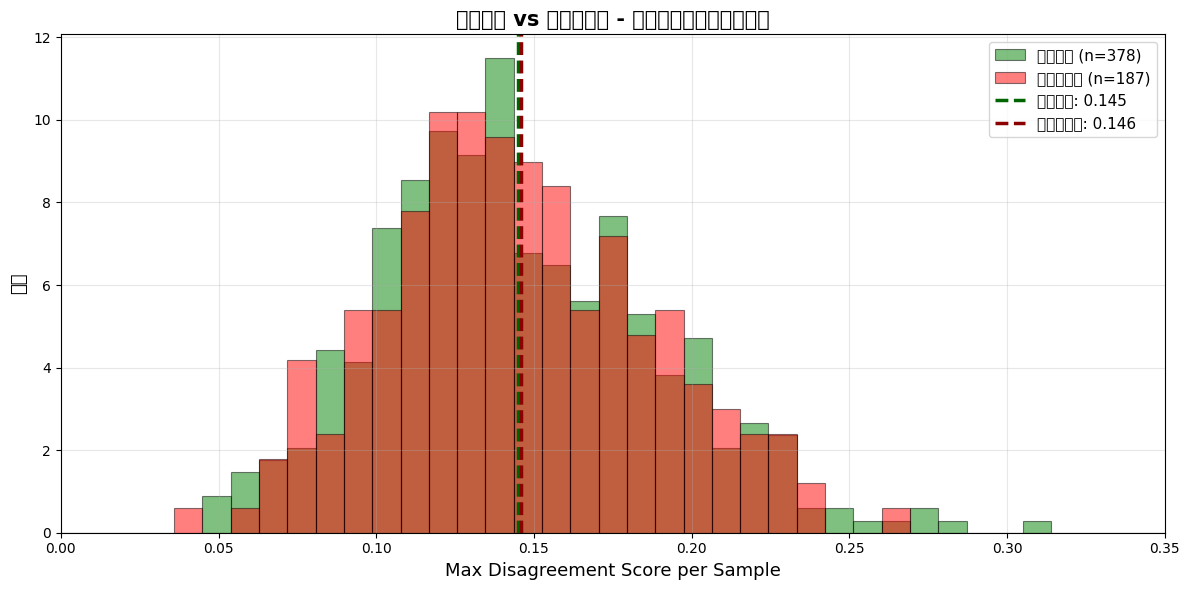

In [18]:
# 创建一个简单的重叠直方图
plt.figure(figsize=(12, 6))

bins = np.linspace(0, 0.35, 40)
plt.hist(correct_scores, bins=bins, alpha=0.5, label=f'答案正确 (n={len(correct_scores)})', 
         color='green', density=True, edgecolor='black', linewidth=0.8)
plt.hist(incorrect_scores, bins=bins, alpha=0.5, label=f'答案不正确 (n={len(incorrect_scores)})', 
         color='red', density=True, edgecolor='black', linewidth=0.8)

# 添加均值线
plt.axvline(np.mean(correct_scores), color='darkgreen', linestyle='--', 
            linewidth=2.5, label=f'正确均值: {np.mean(correct_scores):.3f}')
plt.axvline(np.mean(incorrect_scores), color='darkred', linestyle='--', 
            linewidth=2.5, label=f'不正确均值: {np.mean(incorrect_scores):.3f}')

plt.xlabel('Max Disagreement Score per Sample', fontsize=13)
plt.ylabel('密度', fontsize=13)
plt.title('答案正确 vs 答案不正确 - 最大不一致分数分布对比', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.35)

plt.tight_layout()
plt.savefig('simple_distribution_comparison.png', dpi=300, bbox_inches='tight')
print("✓ 简化版图表已保存: simple_distribution_comparison.png")
plt.show()